In [2]:
import tensorflow as tf 
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt 
from image_datagenerator import DataGenerator
import os

In [3]:
def noise(array):
    noise_factor = 0.4
    noisy_array = array + noise_factor * np.random.normal(
        loc = 0.0, scale = 1.0, size=array.shape
    )
    return np.clip(noisy_array, 0.0, 1.0)

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images, test_images = train_images/255.0, test_images/255.0

validation_images, validation_labels = train_images[:len(train_images) // 10 * 3], train_labels[:len(train_labels) // 10 * 3]

train_images, train_labels = train_images[len(train_images) // 10 * 7:], train_labels[len(train_labels) // 10 * 7:]

train_data = DataGenerator(train_images)
validation_data = DataGenerator(validation_images, shuffle=False, data_aug=False)
test_data = DataGenerator(test_images, shuffle=False, data_aug=False)
noisy_train = noise(train_images)

noisy_test = DataGenerator(test_images, shuffle=False, data_aug=True)

In [5]:
if not os.path.isdir("saved"):
    os.mkdir("saved")

# Save names of files
save_name = os.path.join('saved', 'cifar10_imagedenoiser')
checkpoint_save_name = save_name + '_cnn_net.chk'

<function matplotlib.pyplot.show(close=None, block=None)>

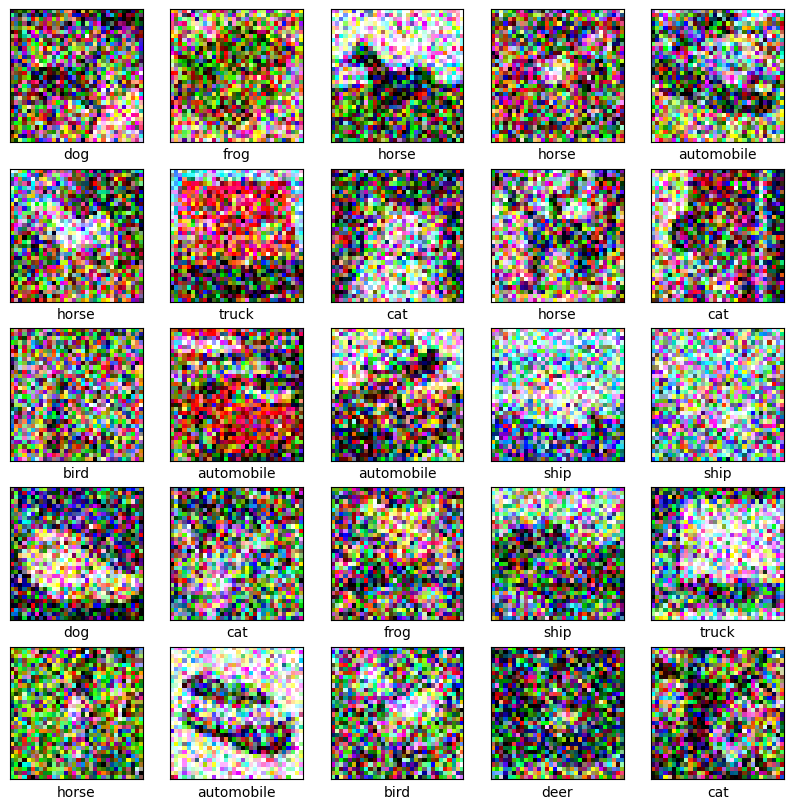

In [6]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(noisy_train[i])
    plt.xlabel(class_names[train_labels[i][0]])

plt.show

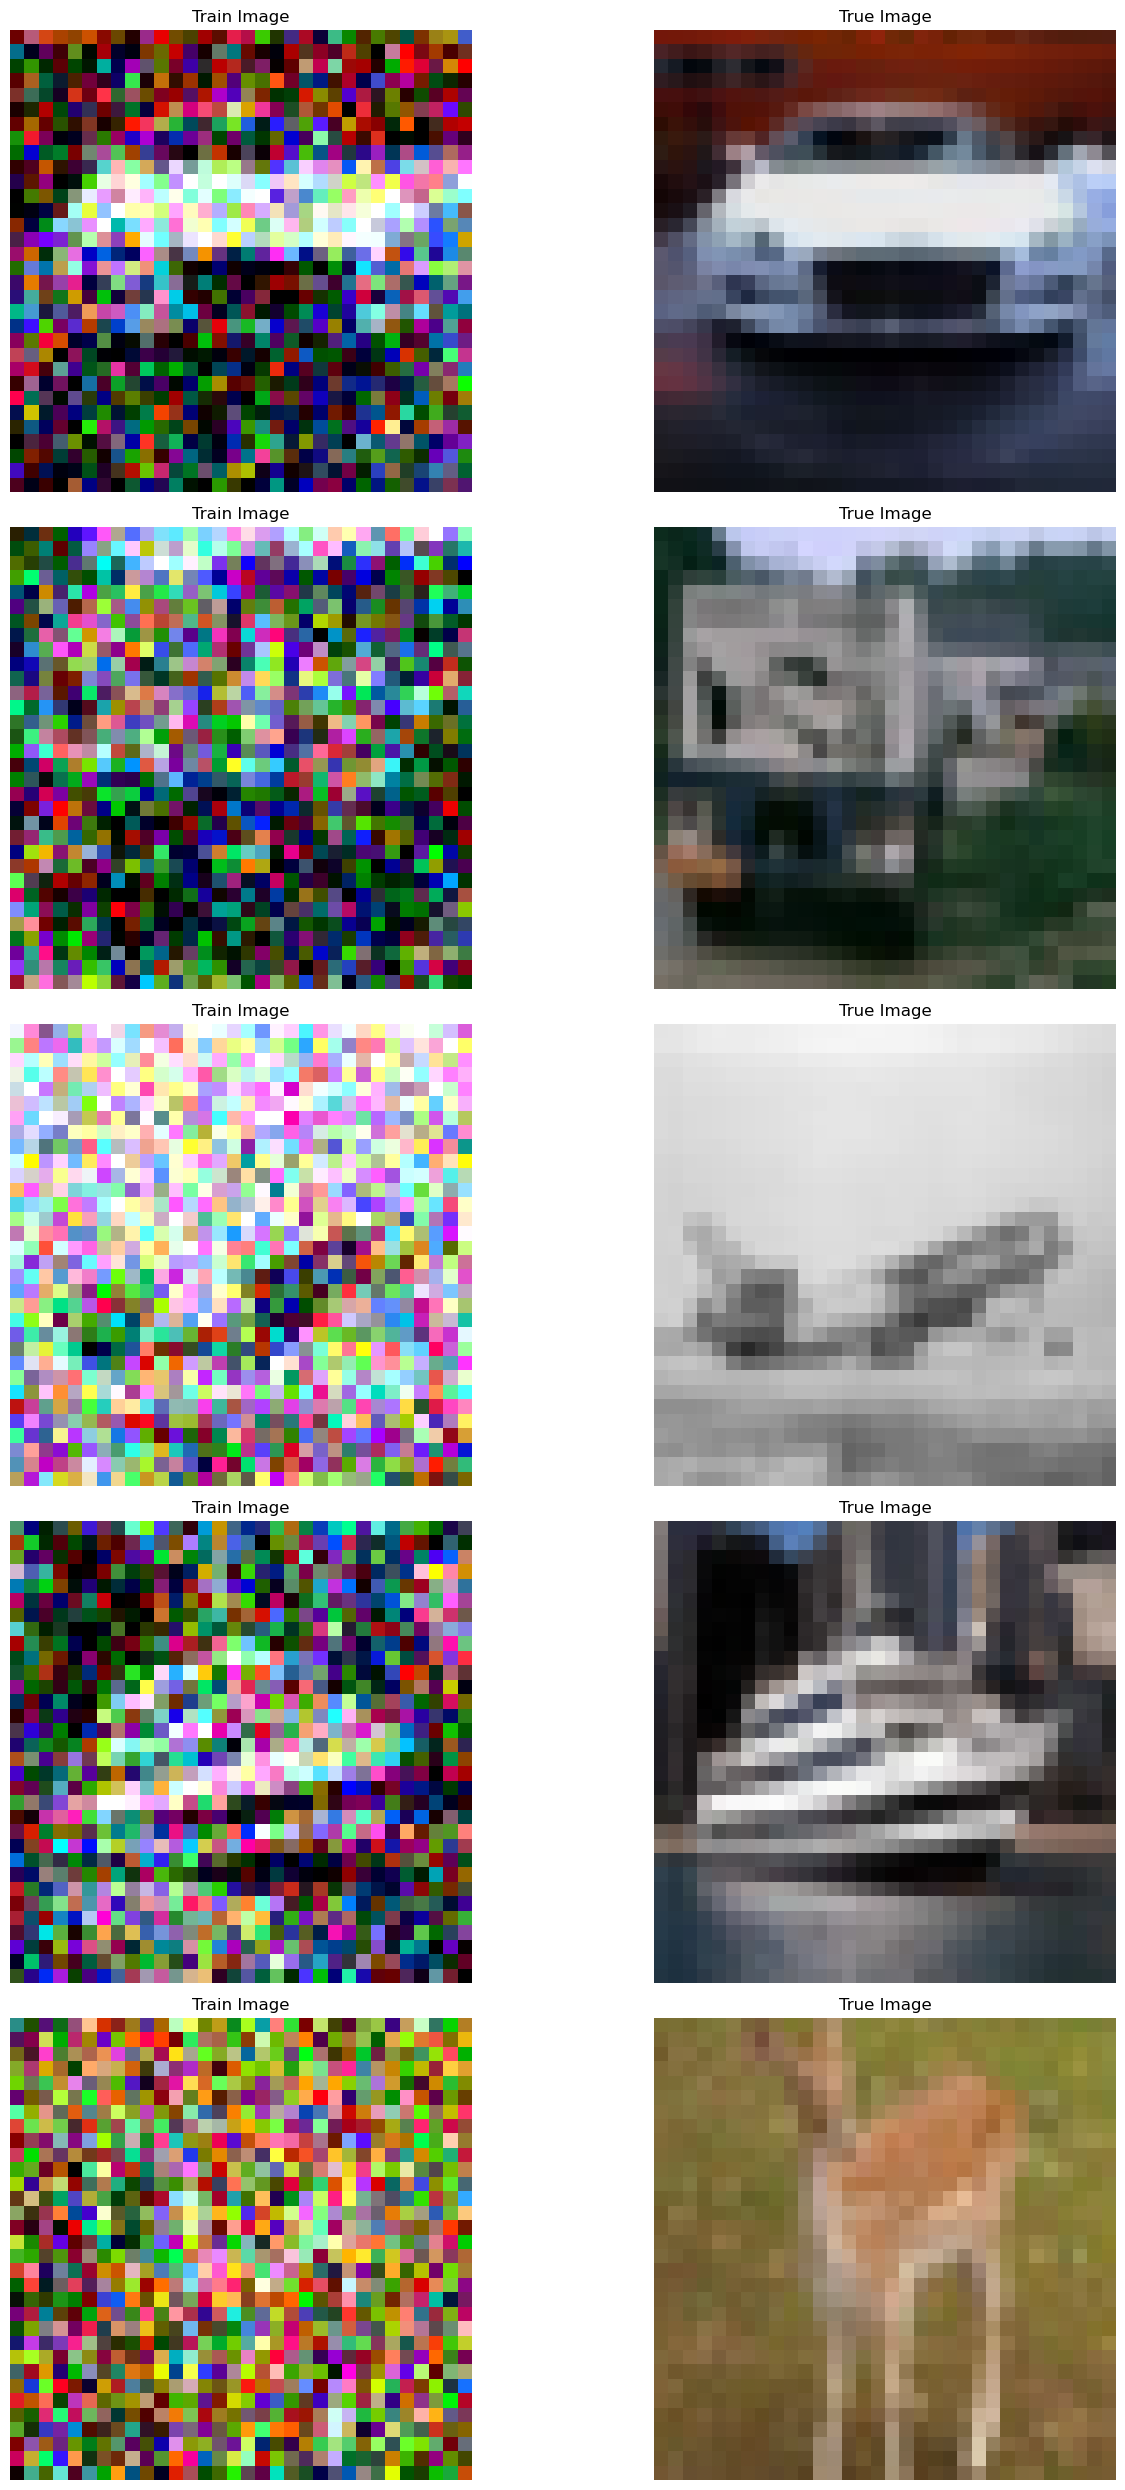

In [7]:
batch_x, batch_y = train_data[0]  

num_images_to_display = min(len(batch_x), 5)  

plt.figure(figsize=(15, 5 * num_images_to_display))

for i in range(num_images_to_display):
    plt.subplot(num_images_to_display, 2, 2 * i + 1)
    plt.imshow(batch_x[i])
    plt.title("Train Image")
    plt.axis('off')

    plt.subplot(num_images_to_display, 2, 2 * i + 2)
    plt.imshow(batch_y[i])
    plt.title("True Image")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation = 'relu'))

model.add(layers.Conv2DTranspose(32, (7, 7), activation = 'linear'))
model.add(layers.Conv2DTranspose(32, (7, 7), activation = 'linear'))
model.add(layers.Conv2DTranspose(32, (10, 10), activation = 'linear'))
model.add(layers.Conv2DTranspose(3, (8, 8), activation = 'linear'))



In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 conv2d_transpose (Conv2DTra  (None, 10, 10, 32)       1

In [10]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_save_name,
    save_weights_only=True,
    monitor='val_mae',
    mode='max',
    save_best_only=True)


In [11]:
model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['mae'])


history = model.fit(train_data, epochs=20,
                    validation_data=validation_data,
                    callbacks=[model_checkpoint_callback])

Epoch 1/20
468/468 [==============================] - 7s 7ms/step - loss: 0.0600 - mae: 0.1842 - val_loss: 0.0900 - val_mae: 0.2521
Epoch 2/20
468/468 [==============================] - 3s 6ms/step - loss: 0.0307 - mae: 0.1361 - val_loss: 0.0754 - val_mae: 0.2333
Epoch 3/20
468/468 [==============================] - 3s 6ms/step - loss: 0.0270 - mae: 0.1272 - val_loss: 0.0517 - val_mae: 0.1890
Epoch 4/20
468/468 [==============================] - 3s 6ms/step - loss: 0.0256 - mae: 0.1236 - val_loss: 0.0470 - val_mae: 0.1787
Epoch 5/20
468/468 [==============================] - 3s 6ms/step - loss: 0.0248 - mae: 0.1214 - val_loss: 0.0429 - val_mae: 0.1700
Epoch 6/20
468/468 [==============================] - 3s 6ms/step - loss: 0.0240 - mae: 0.1193 - val_loss: 0.0382 - val_mae: 0.1587
Epoch 7/20
468/468 [==============================] - 3s 6ms/step - loss: 0.0236 - mae: 0.1179 - val_loss: 0.0332 - val_mae: 0.1455
Epoch 8/20
468/468 [==============================] - 3s 6ms/step - loss: 0.

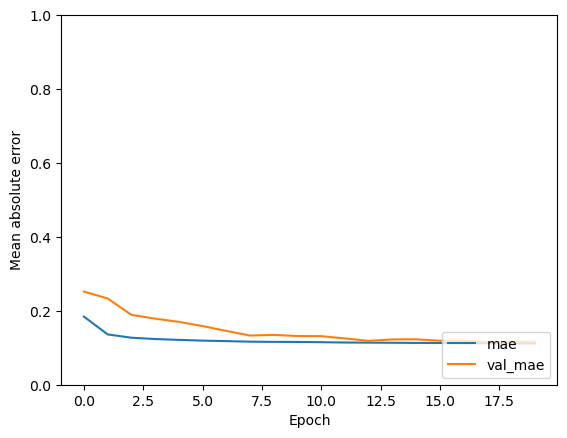

In [12]:
plt.plot(history.history['mae'], label = 'mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('Mean absolute error')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

In [13]:
print(history.history['loss'])

[0.060038186609745026, 0.0306696817278862, 0.027022413909435272, 0.02563285268843174, 0.024786029011011124, 0.024011582136154175, 0.023559868335723877, 0.02304820902645588, 0.02283952198922634, 0.02278745360672474, 0.02254820615053177, 0.022273126989603043, 0.022166654467582703, 0.0220293328166008, 0.021908454596996307, 0.021825481206178665, 0.021750226616859436, 0.021625995635986328, 0.02150789275765419, 0.021477898582816124]


312/312 [==============================] - 1s 2ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


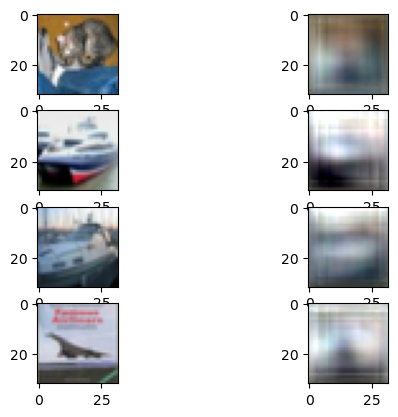

In [14]:
y = model.predict(test_data)

for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(test_images[i])
    plt.subplot(4,2,2*i+2)
    plt.imshow(y[i])

plt.show()

312/312 [==============================] - 1s 2ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


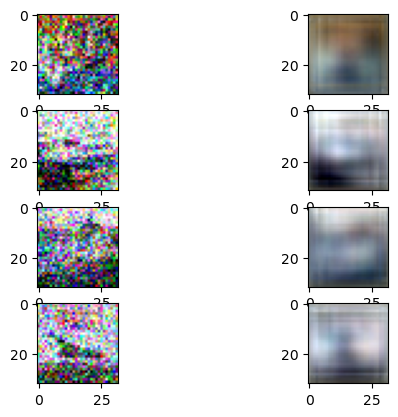

In [15]:
y = model.predict(noisy_test)
batch_x, batch_y = noisy_test[0]

for i in range(4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(batch_x[i])
    plt.subplot(4,2,2*i+2)
    plt.imshow(y[i])

plt.show()

In [16]:
print(batch_x.shape)

(32, 32, 32, 3)
